In [1]:
import os
import json
import math
import warnings
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import pandas as pd
from scipy.special import rel_entr
import scipy.spatial.distance as dist
from scipy.stats import wasserstein_distance

In [2]:
questionaire = json.load(open('./prompts/envent_questionnaire_reader.json', 'r'))
question_to_name = {
    question['Dquestion']: question['Dname'] for question in questionaire
}

NUM_SAMPLE = 10
NUM_QUESTION = len(questionaire)

In [3]:
model_path_lst = glob('./cache/*')

model_results = {}
complete_fix_msg = ''
for model_path in tqdm(model_path_lst, position=0, leave=False):
    
    temperature_list = glob(os.path.join(model_path, 'temp_*'))

    model_name = model_path.split('/')[-1]

    complete_results = {}
    for temperature_results in tqdm(temperature_list, position=1, leave=False):
        
        cur_temp = temperature_results.split('_')[-1]
        chunk_list = glob(f'{temperature_results}/*_parsed.json')
        chunk_list = sorted(
            chunk_list, key=lambda x: int(x.split('/')[-1].split('.')[0].split('_')[0].strip())
        )

        if len(chunk_list) != 24:
            continue

        cur_results = []
        prev_combo = set()
        for chunk_path in tqdm(chunk_list, position=2, leave=False):
            cur_chunk = json.load(open(chunk_path, 'r'))
            cur_chunk, fix_msg = cur_chunk

            complete_fix_msg += '\n\n' + fix_msg

            cur_results.extend(cur_chunk)

        print(f'Temperature: {cur_temp}')
        print(f'Number of complete results: {len(cur_results)}')
        print(f'Number of chunks: {len(chunk_list)}')

        complete_results[cur_temp] = cur_results
    
    model_results[model_name] = complete_results

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 0.5
Number of complete results: 25167
Number of chunks: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 0.25
Number of complete results: 25166
Number of chunks: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 0.75
Number of complete results: 25169
Number of chunks: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 0.0
Number of complete results: 25166
Number of chunks: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 1.25
Number of complete results: 25174
Number of chunks: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 1.0
Number of complete results: 25171
Number of chunks: 24


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 0.5
Number of complete results: 23885
Number of chunks: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 0.25
Number of complete results: 23215
Number of chunks: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 0.75
Number of complete results: 24553
Number of chunks: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 0.0
Number of complete results: 23090
Number of chunks: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 1.25
Number of complete results: 25130
Number of chunks: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Temperature: 1.0
Number of complete results: 24952
Number of chunks: 24


In [4]:
for model_name, model_result in model_results.items():
    for temperature, result_list in model_result.items():
        for result_idx, result in enumerate(result_list):
            cur_response = result['response']

            cur_ratings = []
            for response in cur_response:
                try:
                    cur_response_int = int(response.rsplit(':', 1)[-1].strip())
                    if cur_response_int < 6:
                        cur_ratings.append(cur_response_int)
                except:
                    continue

            model_results[model_name][temperature][result_idx]['ratings'] = cur_ratings
            model_results[model_name][temperature][result_idx]['rating_mean'] = round(np.mean(cur_ratings), 4)
            model_results[model_name][temperature][result_idx]['rating_variance'] = round(np.var(cur_ratings), 4)

/Users/seacow/miniconda3/envs/masktom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/seacow/miniconda3/envs/masktom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/seacow/miniconda3/envs/masktom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/seacow/miniconda3/envs/masktom/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/seacow/miniconda3/envs/masktom/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
for model_name, model_result in model_results.items():
    for temperature, result_list in model_result.items():
        result_list = sorted(result_list, key=lambda x: x['rating_variance'], reverse=True)
        model_results[model_name][temperature] = result_list

In [6]:
model_top_variance = {}
for model_name, model_result in model_results.items():
    top_variance_dict = {}
    for temp, result_lst in model_result.items():
        top_variance = [ele['rating_variance'] for ele in result_lst[:500]]

        top_variance_dict[temp] = top_variance

    model_top_variance[model_name] = top_variance_dict

In [7]:
top_variance_df_dict = {
    'model': [],
    'temperature': [],
    'top_variance': []
}
for idx, (model, top_variance_dict) in enumerate(model_top_variance.items(), 1):

    top_variance_dict = {
        k: v for k, v in sorted(top_variance_dict.items(), key=lambda item: float(item[0]))
    }
    for temp, top_variance in top_variance_dict.items():
        top_variance_df_dict['model'].extend([model] * len(top_variance))
        top_variance_df_dict['temperature'].extend([temp] * len(top_variance))
        top_variance_df_dict['top_variance'].extend(top_variance)

top_variance_df = pd.DataFrame(top_variance_df_dict)

/var/folders/nq/cb3827s949v61zmn_tkmz98c0000gn/T/ipykernel_95298/831886725.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/nq/cb3827s949v61zmn_tkmz98c0000gn/T/ipykernel_95298/831886725.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


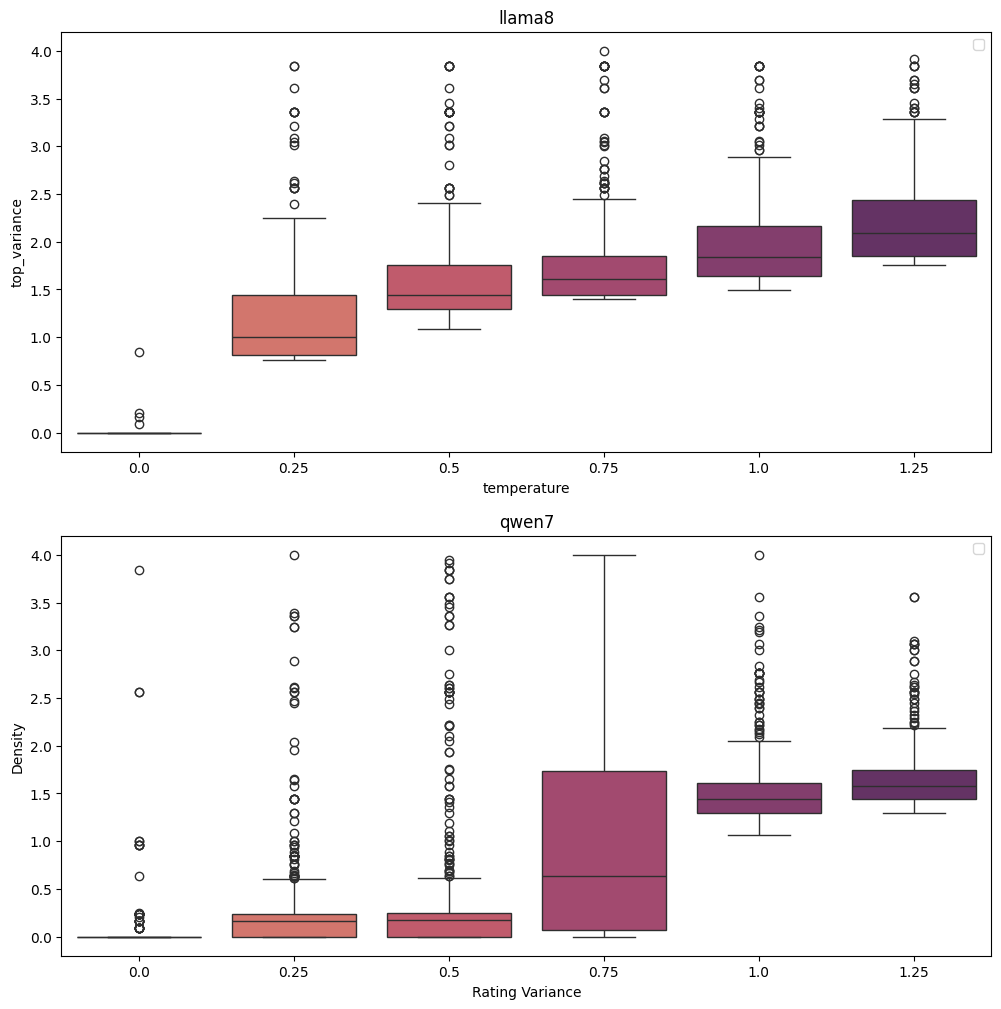

In [8]:
plt.figure(figsize=(12, 12), dpi=100)
for idx, (model, top_variance_dict) in enumerate(model_top_variance.items(), 1):

    ax = plt.subplot(2, 1, idx)

    cur_model_variance_df = top_variance_df[top_variance_df['model'] == model]
    with sns.color_palette("flare"):
        sns.boxplot(
            x='temperature', 
            y='top_variance', 
            data=cur_model_variance_df, 
            ax=ax,
            hue='temperature'
        )

    ax.set_title(model)
    plt.legend()

plt.xlabel('Rating Variance')
plt.ylabel('Density')
plt.show()

In [9]:
for idx, (model, top_variance_dict) in enumerate(model_top_variance.items(), 1):

    print(f'------- {model} --------')
    top_variance_dict = {
        k: v for k, v in sorted(top_variance_dict.items(), key=lambda item: float(item[0]))
    }
    for temp, top_variance in top_variance_dict.items():
        top_variance = [ele for ele in top_variance if not math.isnan(ele)]
        print(f'{temp}: {np.mean(top_variance):.3f}')

print(f'----------------------')

------- llama8 --------
0.0: 0.003
0.25: 1.226
0.5: 1.593
0.75: 1.774
1.0: 1.973
1.25: 2.214
------- qwen7 --------
0.0: 0.042
0.25: 0.284
0.5: 0.429
0.75: 0.978
1.0: 1.536
1.25: 1.648
----------------------


In [10]:
# compare with the variance of the ground truth human label
human_data = json.load(open('./hf_processed/envent_test_repeated_hf_processed.json'))

In [11]:
human_variance_dict = {}
for model_name, model_result in model_results.items():

    cur_human_variance_dict = {}
    for temp, result_lst in model_result.items():
        variance_lst = []
        for entry in result_lst[:500]:

            cur_situation = entry['situation']
            cur_dimension = entry['dimension']

            cur_human_data = [ele for ele in human_data if ele['situation'] == cur_situation]

            # assert len(cur_human_data) == 1
            cur_human_data = cur_human_data[0]
            cur_human_app_lst = cur_human_data['appraisal_d_list']
            cur_human_app_lst = [ele['appraisal_d'][cur_dimension] for ele in cur_human_app_lst]

            variance_lst.append(np.var(cur_human_app_lst))

        cur_human_variance_dict[temp] = variance_lst
    
    human_variance_dict[model_name] = cur_human_variance_dict

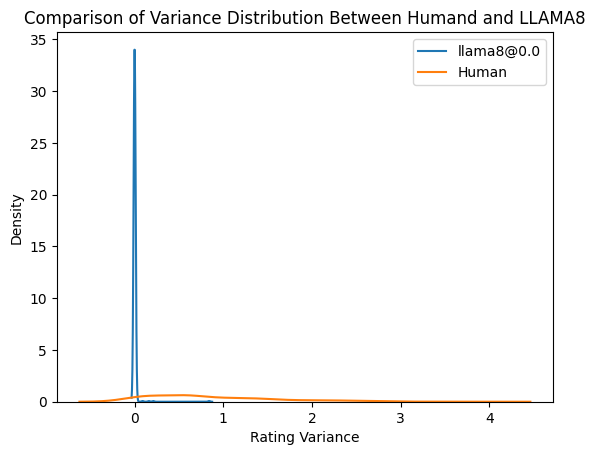

Wasserstein: 0.85388
Supnorm: 3.8400000000000007
KL Div M|H: 0.061823830564738
KL Div H|M: inf





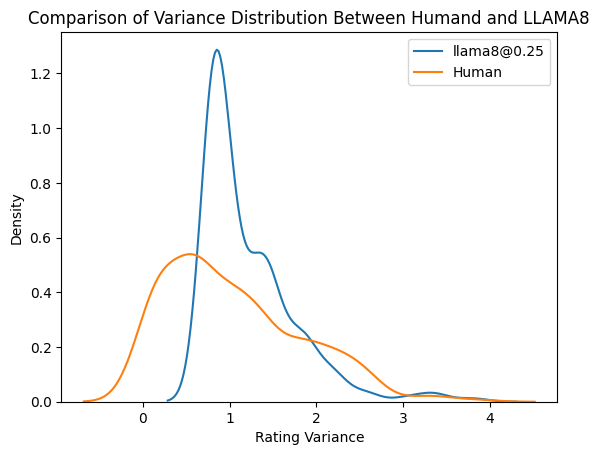

Wasserstein: 0.28402000000000005
Supnorm: 3.37
KL Div M|H: inf
KL Div H|M: 116.73127331539641





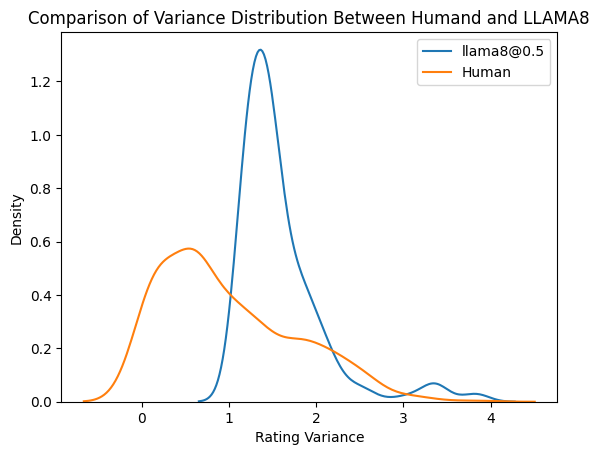

Wasserstein: 0.6131200000000001
Supnorm: 3.84
KL Div M|H: inf
KL Div H|M: -54.879515420774275





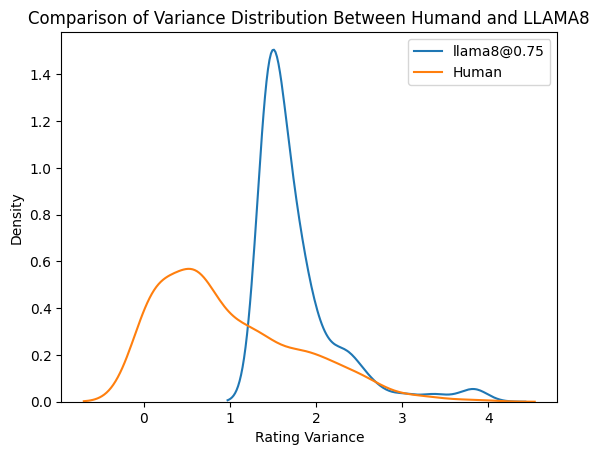

Wasserstein: 0.798635
Supnorm: 3.84
KL Div M|H: inf
KL Div H|M: -99.90531547529652





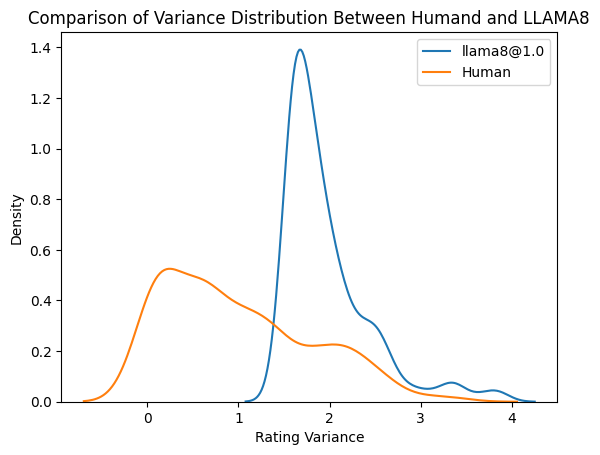

Wasserstein: 0.9810808
Supnorm: 3.84
KL Div M|H: inf
KL Div H|M: -144.04072101344906





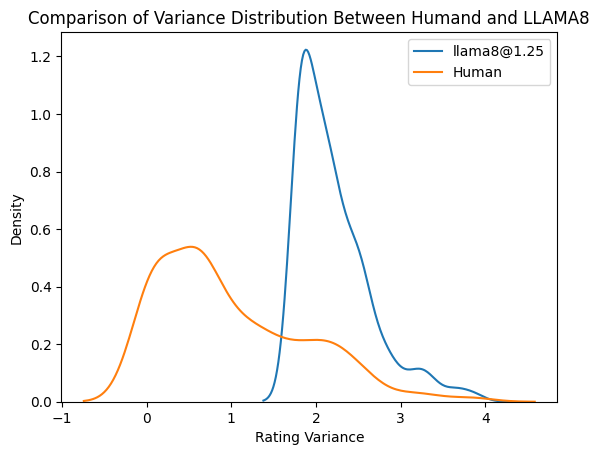

Wasserstein: 1.2245515999999999
Supnorm: 3.9184
KL Div M|H: inf
KL Div H|M: -180.57022787747758





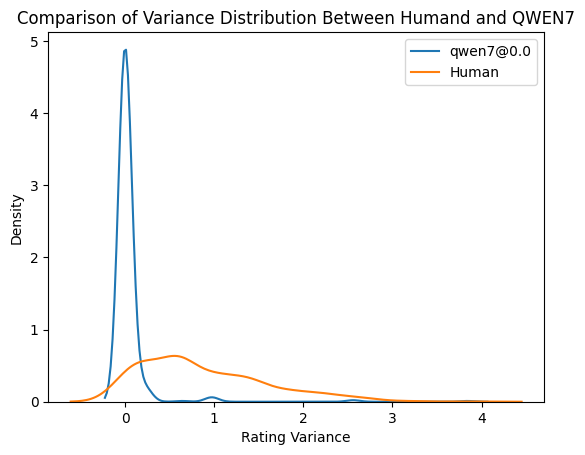

Wasserstein: 0.82962
Supnorm: 3.8400000000000007
KL Div M|H: inf
KL Div H|M: inf





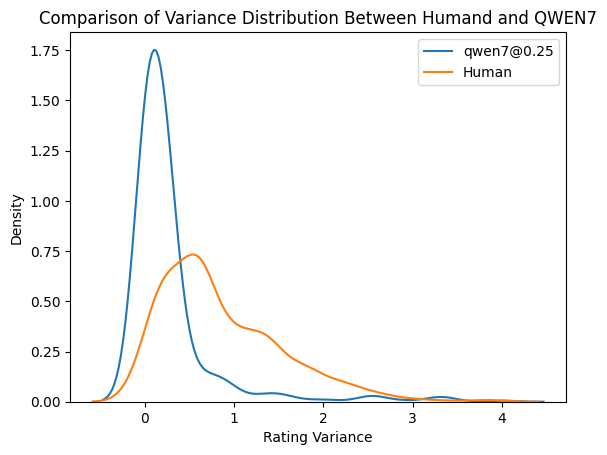

Wasserstein: 0.5817826
Supnorm: 4.0
KL Div M|H: inf
KL Div H|M: inf





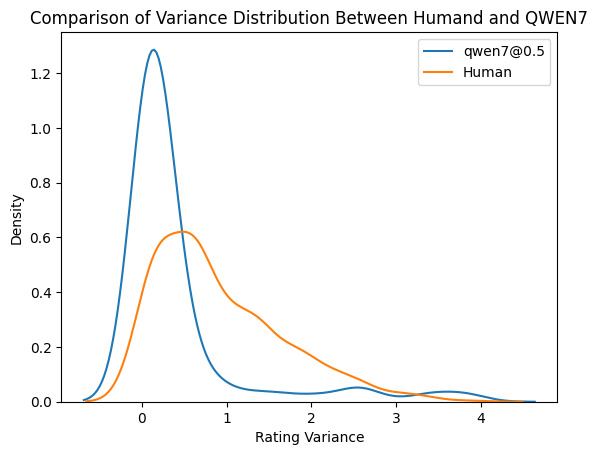

Wasserstein: 0.5375322000000001
Supnorm: 3.9184
KL Div M|H: inf
KL Div H|M: inf





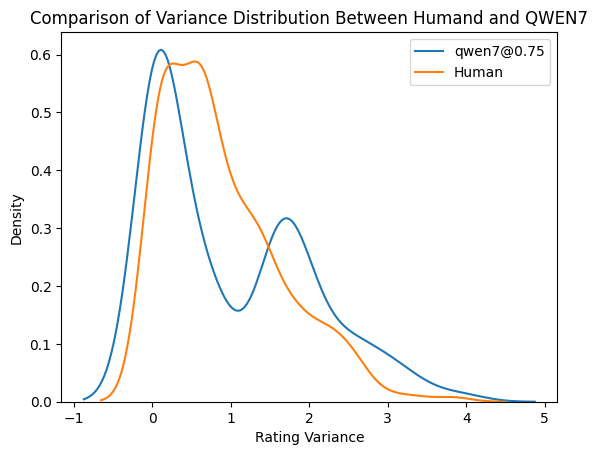

Wasserstein: 0.2740718
Supnorm: 4.0
KL Div M|H: inf
KL Div H|M: inf





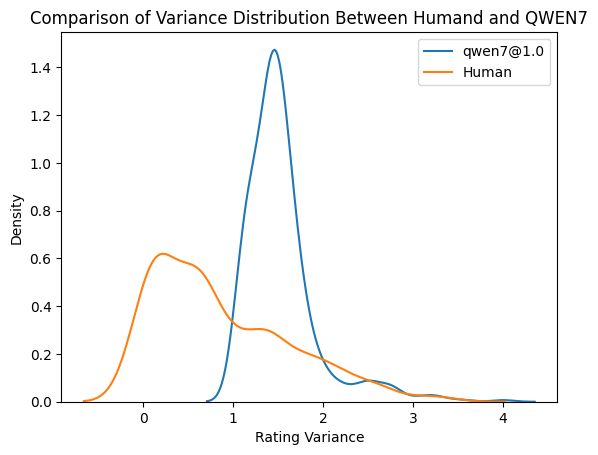

Wasserstein: 0.6737949999999999
Supnorm: 3.84
KL Div M|H: inf
KL Div H|M: -52.35145057086188





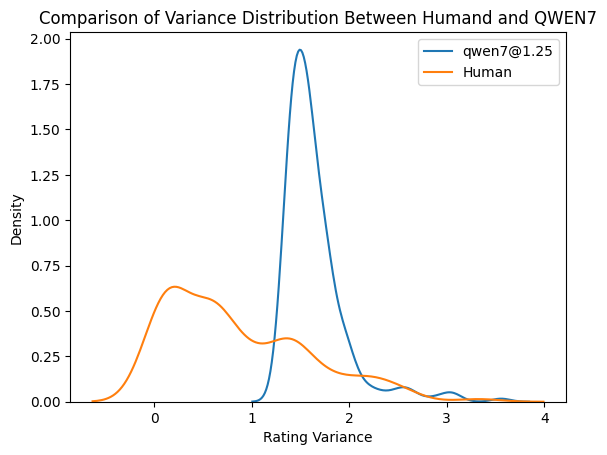

Wasserstein: 0.8032933999999999
Supnorm: 3.0
KL Div M|H: inf
KL Div H|M: -112.64812633665673





In [12]:
for model_name, model_result in model_results.items():

    model_result = {
        k: v for k, v in sorted(model_result.items(), key=lambda item: float(item[0]))
    }
    for temperature, variance_lst in model_result.items():

        cur_human_variance = human_variance_dict[model_name][temperature]
        cur_model_variance = [ele['rating_variance'] for ele in variance_lst]

        cur_model_variance = [ele for ele in cur_model_variance if not math.isnan(ele)][:500]

        sns.kdeplot(cur_model_variance, label=f'{model_name}@{temperature}')
        sns.kdeplot(cur_human_variance, label='Human')
        plt.xlabel('Rating Variance')
        plt.ylabel('Density')
        plt.title(f'Comparison of Variance Distribution Between Humand and {model_name.upper()}')
        plt.legend()
        plt.show()

        print(
            f'Wasserstein: {wasserstein_distance(cur_model_variance, cur_human_variance)}'
        )
        print(
            f'Supnorm: {dist.chebyshev(cur_model_variance, cur_human_variance)}'
        )
        print(
            f'KL Div M|H: {sum(rel_entr(cur_model_variance, cur_human_variance))}'
        )
        print(
            f'KL Div H|M: {sum(rel_entr(cur_human_variance, cur_model_variance))}'
        )
        print('\n\n')

In [13]:
model_nonzero_variance = {
    'model': [],
    'temperature': [],
    'non_zero_variance': []
}
for model_name, model_result in model_results.items():
    top_variance_dict = {}
    model_result = {
        k: v for k, v in sorted(model_result.items(), key=lambda item: float(item[0]))
    }
    for temp, result_lst in model_result.items():
        non_zero_variance = len([ele for ele in result_lst if ele['rating_variance'] > 0])

        model_nonzero_variance['model'].append(model_name)
        model_nonzero_variance['temperature'].append(temp)
        model_nonzero_variance['non_zero_variance'].append(non_zero_variance)

model_nonzero_variance_df = pd.DataFrame(model_nonzero_variance)

<Axes: xlabel='temperature', ylabel='non_zero_variance'>

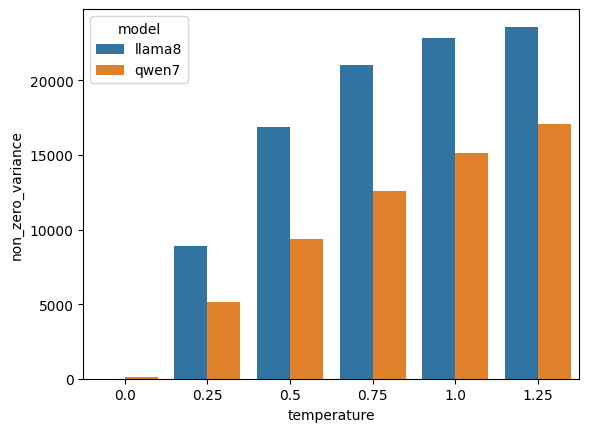

In [14]:
sns.barplot(
    x='temperature', 
    y='non_zero_variance', 
    data=model_nonzero_variance_df,
    hue='model'
)

In [15]:
print(complete_fix_msg)



----------------------------------
Running at Temperature = 0.5
Total corrupted situations: 1
Total corrupted dimensions: 19
Total fixed dimensions: 19
----------------------------------



----------------------------------
Running at Temperature = 0.5
Total corrupted situations: 0
Total corrupted dimensions: 0
Total fixed dimensions: 0
----------------------------------



----------------------------------
Running at Temperature = 0.5
Total corrupted situations: 0
Total corrupted dimensions: 0
Total fixed dimensions: 0
----------------------------------



----------------------------------
Running at Temperature = 0.5
Total corrupted situations: 0
Total corrupted dimensions: 0
Total fixed dimensions: 0
----------------------------------



----------------------------------
Running at Temperature = 0.5
Total corrupted situations: 0
Total corrupted dimensions: 0
Total fixed dimensions: 1
----------------------------------



----------------------------------
Running at Temperatur